# Importing Libraries

In [1]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm

#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

 

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [2]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","vgg19")
PICKLE_PATH = os.path.join(os.getcwd(),"picklevgg19")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)

In [4]:
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

In [5]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg19.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c3': 0, 'c0': 1, 'c4': 2, 'c2': 3, 'c6': 4, 'c5': 5, 'c1': 6, 'c7': 7, 'c8': 8, 'c9': 9}
(22424, 10)


# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [6]:
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:07<00:00, 600.38it/s]


# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of VGG19 model
2. Using the n-1 layers of VGG19 to predict the last layer of it using the flattened image vector 
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [8]:
model = VGG19(include_top=False)
model.summary()

80142336/80134624 [==============================] - 14s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________________________

In [9]:
train_vgg19 = model.predict(train_tensors,verbose=1)
valid_vgg19 = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 79s 561ms/step


In [10]:
print("Train shape",train_vgg19.shape)
print("Validation shape",valid_vgg19.shape)

Train shape (17939, 2, 2, 512)
Validation shape (4485, 2, 2, 512)


In [11]:
train_features = train_vgg19[0]
valid_features = valid_vgg19[0]

In [12]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [13]:
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG19_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG19_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [14]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
plot_model(VGG19_model,to_file=os.path.join(os.getcwd(),"model","vgg19","model_distracted_driver_vgg19.png"),show_shapes=True,show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [16]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [17]:
model_history = VGG19_model.fit(train_vgg19,ytrain,validation_data = (valid_vgg19, ytest),epochs=25, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/25
1073/1122 [===========================>..] - ETA: 0s - loss: 1.7832 - accuracy: 0.4420
Epoch 00001: val_accuracy improved from -inf to 0.55006, saving model to C:\Users\hp\Desktop\car\Distracted-Driver-Detection-master\data\model\vgg19\distracted-01-0.55.hdf5
1122/1122 [==============================] - 1s 1ms/step - loss: 1.7708 - accuracy: 0.4463 - val_loss: 1.4647 - val_accuracy: 0.5501
Epoch 2/25
1118/1122 [============================>.] - ETA: 0s - loss: 1.2802 - accuracy: 0.6370
Epoch 00002: val_accuracy improved from 0.55006 to 0.63278, saving model to C:\Users\hp\Desktop\car\Distracted-Driver-Detection-master\data\model\vgg19\distracted-02-0.63.hdf5
1122/1122 [==============================] - 1s 1ms/step - loss: 1.2799 - accuracy: 0.6372 - val_loss: 1.1863 - val_accuracy: 0.6328
Epoch 3/25
1087/1122 [============================>.] - ETA: 0s - loss: 1.0593 - accuracy: 0.7098
Epoch 00003: val_accuracy improved from 0.63278 to 0.72129, saving model to C:\Users\hp\Des

Epoch 22/25
1107/1122 [============================>.] - ETA: 0s - loss: 0.3938 - accuracy: 0.8944
Epoch 00022: val_accuracy improved from 0.88874 to 0.88963, saving model to C:\Users\hp\Desktop\car\Distracted-Driver-Detection-master\data\model\vgg19\distracted-22-0.89.hdf5
1122/1122 [==============================] - 1s 999us/step - loss: 0.3943 - accuracy: 0.8941 - val_loss: 0.4137 - val_accuracy: 0.8896
Epoch 23/25
1055/1122 [===========================>..] - ETA: 0s - loss: 0.3848 - accuracy: 0.8966
Epoch 00023: val_accuracy did not improve from 0.88963
1122/1122 [==============================] - 1s 962us/step - loss: 0.3859 - accuracy: 0.8960 - val_loss: 0.4251 - val_accuracy: 0.8823
Epoch 24/25
1071/1122 [===========================>..] - ETA: 0s - loss: 0.3789 - accuracy: 0.8978
Epoch 00024: val_accuracy improved from 0.88963 to 0.89565, saving model to C:\Users\hp\Desktop\car\Distracted-Driver-Detection-master\data\model\vgg19\distracted-24-0.90.hdf5
1122/1122 [===============

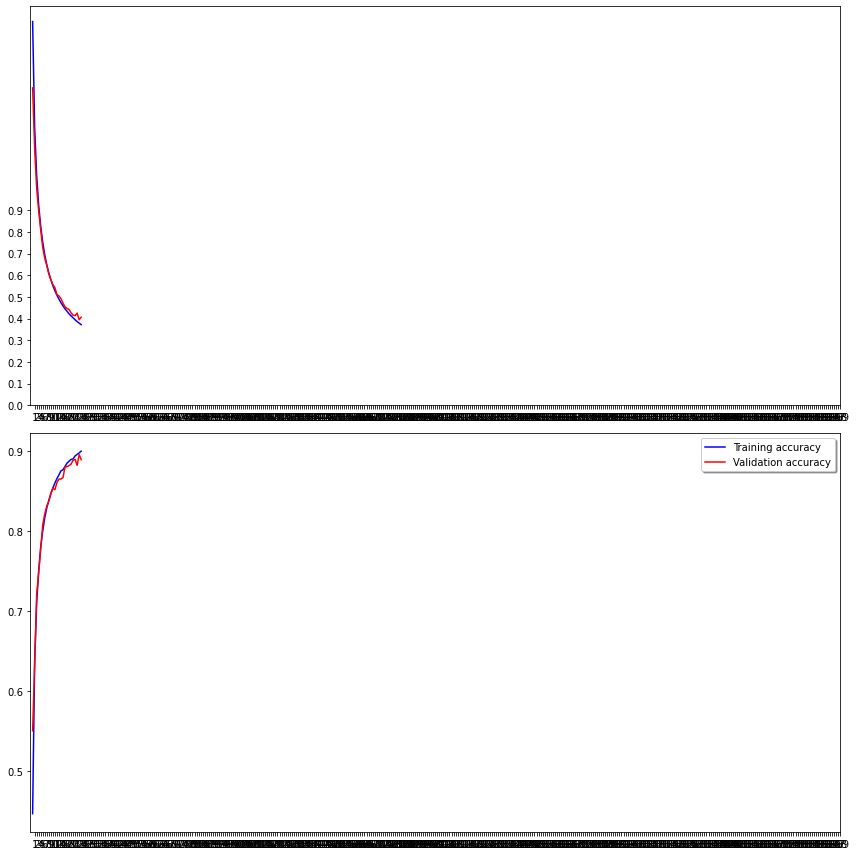

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrixvgg19.png"))
    return fig

In [20]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [21]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = VGG19_model.predict(valid_vgg19,verbose=1)

141/141 [==============================] - 0s 676us/step


## Confusion Matrix

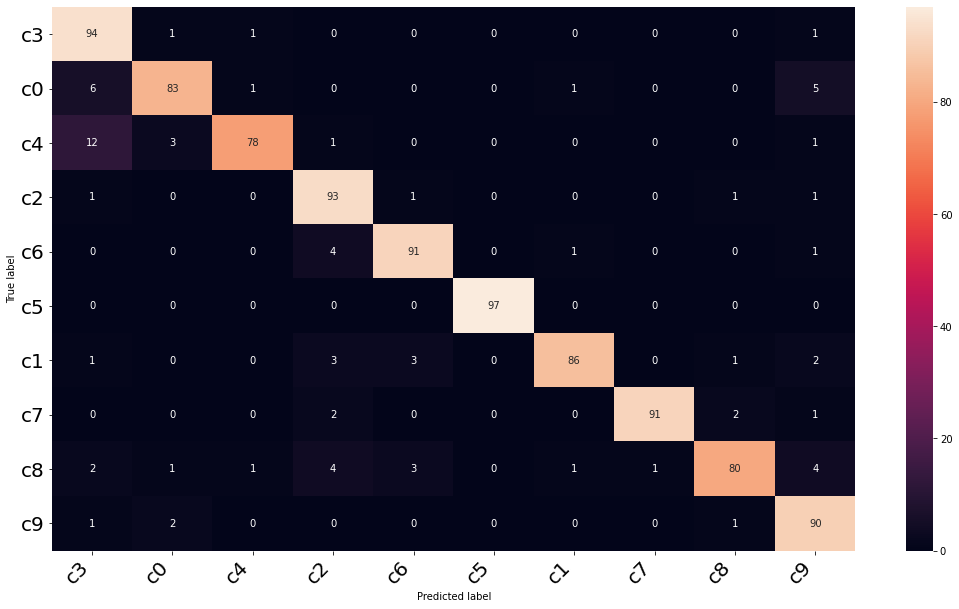

In [22]:
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [23]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [24]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.889409
Precision: 0.894948
Recall: 0.889409
F1 score: 0.889752
